<h1><b>Thematic context vector association based on event uncertainty for twitter  

<h3><b>Import requried libraries

In [1]:
import pandas as pd
import string
import re
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.frequent_patterns import apriori,association_rules
from sklearn.metrics.pairwise import cosine_similarity
import spacy

import preprocessor as p
from scipy.stats import entropy
from math import log2
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load('en_core_web_lg')  
#nlp = spacy.load('en_core_web_sm')
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
%matplotlib inline

/root/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



<h3><b>Load twitter dataset from kaggle

In [2]:
df = pd.read_csv('datasets_corona_May_Tweets.csv',engine='python')

In [3]:
df=df[['created_at','text']]

In [4]:
df['date'] = pd.to_datetime(df['created_at'])

In [5]:
clean_data =df['text'].apply(lambda x: p.clean(x))

In [6]:
def clean_textWithoutSteam(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    #after tweepy preprocessing the colon symbol left remain after    
    tweet = re.sub(r':', '', text_rc)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #filter using NLTK library append it to a string
    tokens = re.split('\W+', tweet)    # tokenization
    text = [word for word in tokens if word not in stopword]  # remove stopwords
    return text

In [7]:
#TF
def countVect(text):
    countVectorizer = CountVectorizer(token_pattern=r"(?u)\b+\b",analyzer=clean_textWithoutSteam,stop_words=None) 
    countVector = countVectorizer.fit_transform(text)
    dtm = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())

    return (dtm)

df_withoutStem = countVect(clean_data)

In [8]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidfVect(text):
    tfidfVectorizer = TfidfVectorizer(token_pattern=r"(?u)\b+\b",analyzer=clean_textWithoutSteam,stop_words=None) 
    tfidfVector = tfidfVectorizer.fit_transform(text)
    dtm = pd.DataFrame(tfidfVector.toarray(), columns=tfidfVectorizer.get_feature_names())

    return (dtm)

In [9]:
#probability of words
total_w = len(df_withoutStem.iloc[:,1:].columns)
p_AllWords = df_withoutStem.iloc[:,1:].sum().apply(lambda x: x/total_w)
p_AllWords

abandon              0.000212
abbey                0.000212
abdiaziz             0.000212
abilene              0.000212
able                 0.000423
                       ...   
zoey                 0.000212
zombieapocalyptic    0.000212
zombies              0.000212
zone                 0.002538
zoom                 0.000423
Length: 4728, dtype: float64

In [170]:
df_withoutStem.columns[-1050:-1000]

Index(['sarscov', 'sas', 'satisfy', 'saturday', 'saudi', 'save', 'saving',
       'saw', 'say', 'saying', 'says', 'sayyes', 'scale', 'scalp', 'scamdemic',
       'scapegoating', 'scar', 'scheduled', 'scheme', 'schoesler', 'schools',
       'science', 'sciencebased', 'sciencerelated', 'sciencewhat',
       'scientific', 'scientists', 'scorecard', 'scored', 'scores', 'scott',
       'scream', 'screen', 'screened', 'screw', 'se', 'sea', 'seafarers',
       'seafarershope', 'sealing', 'sean', 'season', 'seasonal', 'seasondown',
       'seasonsheres', 'seat', 'second', 'secondary', 'secretary',
       'secretarys'],
      dtype='object')

In [171]:
#action alive announce business brilliant cycling corona covid coronavirus scientists

<h3><b>Query

In [221]:
# 'What has been published about medical care?'
doc1 = 'what brilliant scientists has announce about medical care for alive in action of covid or corona or coronavirus?'
doc2 = 'What has been published about medical care?'
clean_doc1 =p.clean(doc2)

In [222]:
tok = clean_textWithoutSteam(clean_doc1)

In [223]:
token=[]
for i in tok:
    if i in p_AllWords.index:
        token.append(i)

In [224]:
p_token = []
for i in token:
    p_token.append(p_AllWords[i])

In [225]:
df_tok1 = pd.DataFrame([token,p_token],index=['token','prob']).transpose()

In [226]:
df_tok1

,token,prob
0,medical,0.00486464
1,care,0.00380711


In [227]:
#tf
df_tokTf = []
for i in token:
    df_tok = df[df['text'].apply(lambda x: i in x)]
    clean_data_tags =df_tok['text'].apply(lambda x: p.clean(x))
    df_tokTf.append(tfidfVect(clean_data_tags))
    
df_tokTfDtm = pd.DataFrame(df_tokTf)[0][0].append(pd.DataFrame(df_tokTf)[0][1]).fillna(0)
df_tokTfDtm = df_tokTfDtm.drop_duplicates(subset=df_tokTfDtm.columns.values, keep='first')
x_tf = []
for i in range(len(df_tokTfDtm.iloc[:,1:])):
    x_tf = x_tf + list(df_tokTfDtm.iloc[i,1:])
    
x_tf1 = np.array(x_tf).reshape(-1,1)

In [228]:
#tfidf
df_tokTfidf = []
for i in token:
    df_tokidf = df[df['text'].apply(lambda x: i in x)]
    clean_data_tags =df_tokidf['text'].apply(lambda x: p.clean(x))
    df_tokTfidf.append(tfidfVect(clean_data_tags))
    
df_tokTfidfDtm = pd.DataFrame(df_tokTfidf)[0][0].append(pd.DataFrame(df_tokTfidf)[0][1]).fillna(0)
df_tokTfidfDtm = df_tokTfidfDtm.drop_duplicates(subset=df_tokTfidfDtm.columns.values, keep='first')
x_tfidf = []
for i in range(len(df_tokTfidfDtm.iloc[:,1:])):
    x_tfidf = x_tfidf + list(df_tokTfidfDtm.iloc[i,1:])
    
x_tfidf1 = np.array(x_tfidf).reshape(-1,1)

In [229]:
#Intersection  P(tags I word) = n(words from specific hashtag) / n(total words from all hashtags)
total_wsI = df_withoutStem.iloc[:,1:].sum().sum()
p_tokIword = []
for i in token:
    df_tokWord = df[df['text'].apply(lambda x: i in x)]
    df_tokWord.reset_index(inplace=True)
    clean_data_tags =df_tokWord['text'].apply(lambda x: p.clean(x))
    df_wsI = countVect(clean_data_tags)
   # print(total_wsI)
    p_tokIword.append(df_wsI.iloc[:,1:].sum().apply(lambda x: x/total_wsI))
    

prob_tokIword = pd.DataFrame(p_tokIword)
prob_tokIword.fillna(0,inplace=True)

In [230]:
prob_tokIword

,accidental,according,amp,anymore,artemilife,away,based,believe,belong,cairo,...,wholesome,wish,workerswatch,world,worldwide,would,woundsthat,wrong,yay,yrs
0,0.000034,0.000034,0.000238,0.000068,0.000034,0.000034,0.000034,0.000034,0.000034,0.000068,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000034,0.000034,0.000034,0.000068,0.000034,0.000034,0.000102,0.000034,0.000034,0.000034


In [231]:
prob_uncertinity = prob_tokIword.div(df_tok1['prob'],axis=0)

prob_uncertinity.index = df_tok1['token']
prob_uncertinity

,accidental,according,amp,anymore,artemilife,away,based,believe,belong,cairo,...,wholesome,wish,workerswatch,world,worldwide,would,woundsthat,wrong,yay,yrs
token,,,,,,,,,,,,,,,,,,,,,
medical,0.00698465,0.00698465,0.0488925,0.0139693,0.00698465,0.00698465,0.00698465,0.00698465,0.00698465,0.0139693,...,0,0,0,0,0,0,0,0,0,0
care,0,0,0.0267745,0,0,0,0,0,0,0,...,0.00892483,0.00892483,0.00892483,0.0178497,0.00892483,0.00892483,0.0267745,0.00892483,0.00892483,0.00892483


In [232]:
df_tokWord = df[df['text'].apply(lambda x: 'medical' in x)]
df_tokWord.reset_index(inplace=True)
clean_data_tags =df_tokWord['text'].apply(lambda x: p.clean(x))
df_wsI = countVect(clean_data_tags)

In [233]:
#uncertinity
con_prob = prob_uncertinity.transpose()
tot = []
totE = []
totI = []

def unc(i,x,t_words,colm):
    global COUNT
    c_prob = con_prob[i].loc[colm[COUNT]]
    s_word = x
    
    E  = -1/t_words * log2(t_words) - 1/s_word * log2(s_word) - c_prob * log2(1/c_prob)
   # print(E)
    ig = E * 1/s_word
    un = 1- ig
    COUNT = COUNT+1
    #print(COUNT)
    return un

def entr(i,x,t_words,colm):
    global COUNT
    c_prob = con_prob[i].loc[colm[COUNT]]
    s_word = x
    E  = -1/t_words * log2(t_words) - 1/s_word * log2(s_word) - c_prob * log2(1/c_prob)
    COUNT = COUNT+1
    #print(COUNT)
    return E

def inf(i,x,t_words,colm):
    global COUNT
    c_prob = con_prob[i].loc[colm[COUNT]]
    s_word = x
    
    E  = -1/t_words * log2(t_words) - 1/s_word * log2(s_word) - c_prob * log2(1/c_prob)
   # print(E)
    ig = E * 1/s_word
    COUNT = COUNT+1
    #print(COUNT)
    return ig


for i in token:
    df_tokWord = df[df['text'].apply(lambda x: i in x)]
    df_tokWord.reset_index(inplace=True)
    clean_data_tags =df_tokWord['text'].apply(lambda x: p.clean(x))
    df_wsI = countVect(clean_data_tags)
    t_words = len(df_wsI.iloc[:,1:].columns)
    un_tot = []
    
    COUNT = 0
    tot.append(df_wsI.iloc[:,1:].sum().apply(lambda x: unc(i,x,t_words,df_wsI.iloc[:,1:].columns)))
    COUNT = 0
    totE.append(df_wsI.iloc[:,1:].sum().apply(lambda x: entr(i,x,t_words,df_wsI.iloc[:,1:].columns)))
    COUNT = 0
    totI.append(df_wsI.iloc[:,1:].sum().apply(lambda x: inf(i,x,t_words,df_wsI.iloc[:,1:].columns)))
    
unc_eventWord = pd.DataFrame(tot)
unc_eventWord.fillna(0,inplace=True)

uncE_eventWord = pd.DataFrame(totE)
uncE_eventWord.fillna(0,inplace=True)

uncI_eventWord = pd.DataFrame(totI)
uncI_eventWord.fillna(0,inplace=True)

#uncertantiy
unc_eventWord.index = token
uncE_eventWord.index = token
uncI_eventWord.index = token
unc_eventWord

,accidental,according,amp,anymore,artemilife,away,based,believe,belong,cairo,...,wholesome,wish,workerswatch,world,worldwide,would,woundsthat,wrong,yay,yrs
medical,1.117518,1.117518,1.097348,1.326785,1.117518,1.117518,1.117518,1.117518,1.117518,1.326785,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
care,0.000000,0.000000,1.235208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.098221,1.098221,1.098221,1.320565,1.098221,1.098221,1.235208,1.098221,1.098221,1.098221


<h3><b> Association between event and keywords

In [234]:
from nltk.corpus import wordnet 
a =[]
c = []
for i in df_tok1['token']:
    b=[]
    n=[]
    for j in unc_eventWord.columns:
        if (nlp(j).similarity(nlp(i))) != 0:
            b.append([unc_eventWord[j][i],j])
            n.append(j)
    a.append(b)
    c.append(n)

/root/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/root/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/root/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/root/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/root/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/root/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/root/anaconda3/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/root/anaconda3/lib/python3.7/runp

In [235]:
x = list(pd.DataFrame(a[0])[0])+(list(pd.DataFrame(a[1])[0]))

In [236]:
x1 = (np.array(x).reshape(-1, 1) )#.shape

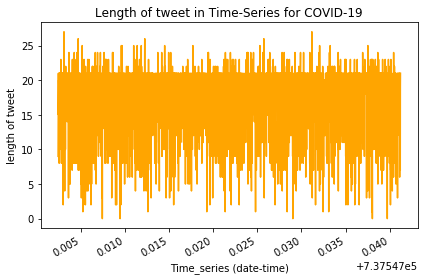

In [262]:
import matplotlib
dates = matplotlib.dates.date2num(df['date'])
pts = clean_data.apply(lambda x: len(x.split()[1:]))
plt.plot(dates,pts,color='orange')
plt.gcf().autofmt_xdate()
plt.title('Length of tweet in Time-Series of COVID-19')
plt.ylabel('length of tweet')
plt.xlabel('Time_series (date-time)')
plt.tight_layout()

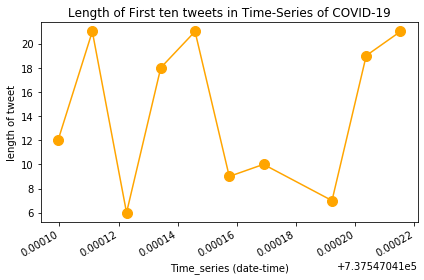

In [264]:
import matplotlib
dates = matplotlib.dates.date2num(df['date'].iloc[:10])
pts = clean_data.iloc[:10].apply(lambda x: len(x.split()[1:]))
plt.plot(dates,pts,color='orange',marker='o',markersize=10)
plt.gcf().autofmt_xdate()
plt.title('Length of First ten tweets in Time-Series of COVID-19')
plt.ylabel('length of tweet')
plt.xlabel('Time_series (date-time)')
plt.tight_layout()

In [239]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [240]:
Kmean = KMeans(n_clusters=9)
Kmean.fit(x1)
theme=silhouette_score(x1,Kmean.labels_)

In [241]:
wss = []
for i in range(2,15):
    km = KMeans(n_clusters=i)
    km.fit(x1)
    wss.append(km.inertia_)

Text(0.5, 1.0, 'Clusterwise Inertia')

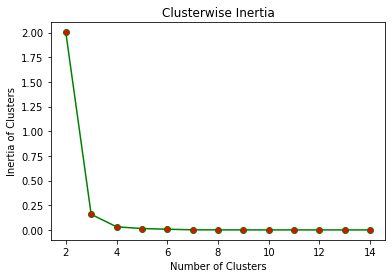

In [242]:
plt.plot(range(2,15),wss,marker='o',markerfacecolor='red',color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia of Clusters')
plt.title('Clusterwise Inertia')

In [243]:
# TF
Kmean = KMeans(n_clusters=9)
Kmean.fit(x_tf1)
tf=silhouette_score(x_tf1,Kmean.labels_)

In [244]:
# TF-IDF
Kmean = KMeans(n_clusters=9)
Kmean.fit(x_tfidf1)
tfIdf=silhouette_score(x_tfidf1,Kmean.labels_)

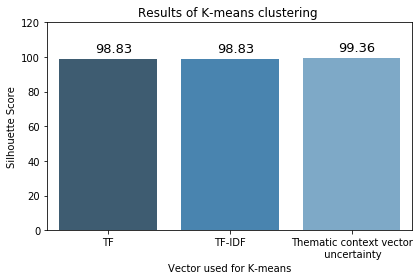

In [245]:
plt.figure(figsize=(6,4))
g= sns.barplot(x=['TF','TF-IDF',"Thematic context vector\n uncertainty"],y=[tf*100,tfIdf*100,theme*100],palette="Blues_d")

ax=g
#annotate axis = seaborn axis
for pt in ax.patches:
             ax.annotate("%.2f" % pt.get_height(), (pt.get_x() + pt.get_width() / 1.8, pt.get_height()),
                 ha='center', va='center', fontsize=13, xytext=(0,10),
                 textcoords='offset points')
_ = g.set_ylim(0,120) #To make space for the annotations

plt.title('Results of K-means clustering ')
plt.xlabel('Vector used for K-means')
plt.ylabel('Silhouette Score')
plt.tight_layout()

In [246]:
all_df = []
for i in range(len(a)):
    temp = pd.DataFrame(a[i]).transpose()
    temp.index = [token[i],'Keywords']
    temp.columns = temp.iloc[1,:]
    temp.drop('Keywords',axis=0,inplace=True)
    all_df.append(temp)

In [247]:
unc_EW = pd.concat(all_df)

In [248]:
unc_EW.fillna(0,inplace=True)

In [249]:
unc_EW

Keywords,accidental,according,amp,anymore,away,based,believe,belong,cairo,capped,...,watch,watching,wholesome,wish,world,worldwide,would,wrong,yay,yrs
medical,1.117518,1.117518,1.097348,1.326785,1.117518,1.117518,1.117518,1.117518,1.326785,1.237557,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
care,0.000000,0.000000,1.235208,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.098221,1.098221,1.098221,1.098221,1.320565,1.098221,1.098221,1.098221,1.098221,1.098221


In [287]:
cnt = pd.DataFrame(df_withoutStem[list(unc_EW.columns)].sum())

In [288]:
cnt = cnt.transpose()

In [388]:
0.000000+2 /tot

0.0005232862375719519

In [386]:
cnt

,accidental,according,amp,anymore,away,based,believe,belong,cairo,capped,...,watch,watching,wholesome,wish,world,worldwide,would,wrong,yay,yrs
0,2,6,171,9,14,4,7,1,2,3,...,40,7,1,2,36,5,37,7,1,1


In [417]:
pd.DataFrame((unc_EW.iloc[1,:]+cnt / tot).iloc[0,:].sort_values(ascending=False)).transpose()[['providers','service','approximately','rest','neglect','heal']]#.head(50)

,providers,service,approximately,rest,neglect,heal
0,1.321089,1.322659,1.321089,1.237301,1.321089,1.235993


In [410]:
pd.DataFrame((unc_EW.iloc[0,:]+cnt / tot).iloc[0,:].sort_values(ascending=True)).transpose()['virus']

0    0.007326
Name: virus, dtype: float64

In [389]:
ranked = []
tot = df_withoutStem[list(unc_EW.columns)].sum().sum()
for i in range(len(unc_EW)):
    temp = (unc_EW.iloc[0,:] + cnt /tot
    ranked.append(temp)

In [250]:
#Top ten words/keywords of each events
label=[]
coln=[]
val=[]
for i in range(len(unc_EW)):
    s = pd.DataFrame(unc_EW.iloc[i,:].sort_values(ascending=False).head(50))
    label.append(s.index)
    coln.append(s.columns)
    val.append(s.values)

top_CwordsWithHash = pd.DataFrame(label,index=pd.DataFrame(coln).values).transpose()

In [251]:
#uncertanity values of top keywords
#pd.DataFrame(list(map(np.ravel, val)),index=pd.DataFrame(coln).values).transpose()[[token]].iloc[1:,:]

In [252]:
#top_CwordsWithHash

In [253]:
#top_CwordsWithHash

In [254]:
forplt = top_CwordsWithHash[[token]]
forplt[:10]

,"(medical,)","(care,)"
0,morbidities,conducting
1,die,albert
2,died,lloydminster
3,talking,entities
4,saying,approximately
5,generally,area
6,cairo,navajo
7,dean,neglect
8,anymore,special
9,im,number


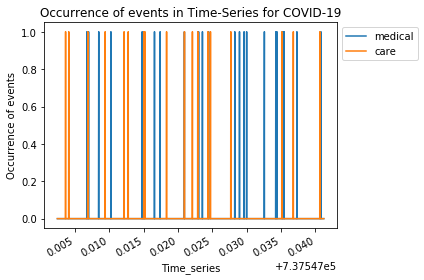

In [268]:
import matplotlib
dates = matplotlib.dates.date2num(df['date'])
plt.plot(dates, df_withoutStem[token])
plt.gcf().autofmt_xdate()
plt.title('Occurrence of events in Time-Series for COVID-19')
plt.ylabel('Occurrence of events')
plt.xlabel('Time_series')
plt.legend(token,loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()

In [ ]:
import matplotlib
dates = matplotlib.dates.date2num(df['date'].iloc[:100])
plt.plot(dates, df_withoutStem.iloc[:100,:][token], marker='o', markersize=3)
plt.gcf().autofmt_xdate()
plt.title('Occurrence of events in Time-Series for COVID-19')
plt.ylabel('Occurrence of event')
plt.xlabel('Time_series')
plt.legend(token)
plt.tight_layout()